# コード3-2：各種回帰モデルの実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

一般化線形モデルの実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [67]:
## 必要があればインストール
# install.packages(c("ggplot2", "patchwork"))

In [2]:
rm(list = ls(all = TRUE))
library(ggplot2)
library(patchwork)

## 一般化線形モデル

数学コラム０２で言及された一般化線形モデルのうち以下の実装を紹介する。

- ポアソン回帰
- 正規分布に基づく回帰
- 負の二項分布に基づく回帰（未）

Rの`stats`ライブラリにある`glm`関数を用いる

- https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/glm

## ポアソン回帰

データ$y_i$、説明変数$x_i={0, 1,..., 99, 100}$で、誤差構造を

$$
P(y_i = k | \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}
$$

と考える。ポアソン分布の母数$\lambda$について線形予測子を用いて

$$
\psi \left( \lambda \right) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

と表し、リンク関数$\psi$を対数関数とすることで、回帰を行う。

In [41]:
nobs1 <- 100 ## データの数
x <- 1:nobs1 ## 説明変数
set.seed(5432) ## 乱数のシード値
lny <- rpois(n = nobs1, lambda = exp(-(.03*x + .0001*x**2 - 1.0))) ## ポアソン分布からランダムサンプリング

In [42]:
length(lny)

[1] 100

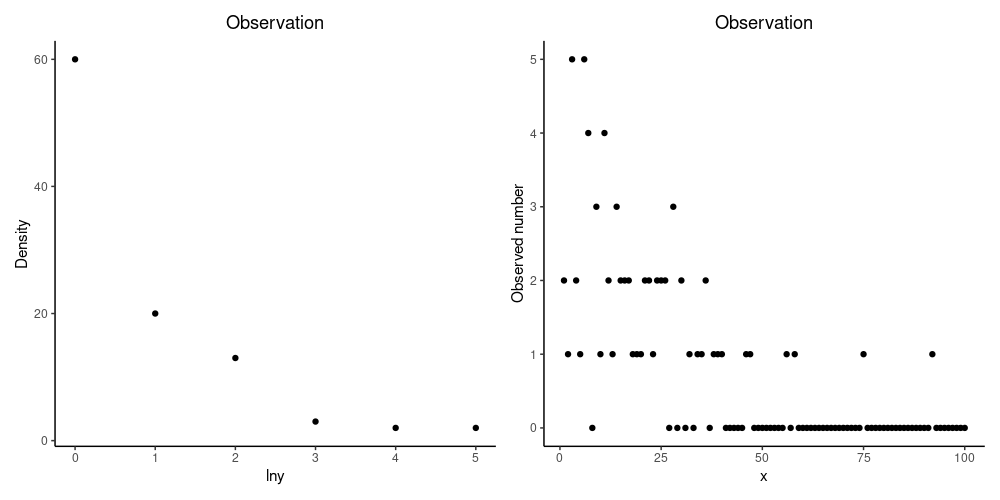

In [43]:
## データのプロット

p1 <- ggplot(data = data.frame(x = as.numeric(names(table(lny))),
                               y = as.numeric(table(lny))),
             aes(x = x, y = y)) +
    geom_point() +
    xlab("lny") +
    ylab("Density") +
    labs(title = "Observation") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(data = data.frame(x = x, y = lny), aes(x = x, y = y)) +
    geom_point() +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

In [44]:
## 誤差構造：ポアソン分布 / リンク関数：対数 / 線形予測子：beta_0 + beta_1*x^2 + beta_2*x^2
data_poisson <- data.frame(x1 = x, x2 = x^2, y = lny)
poisson_log <- glm(y ~ x1 + x2, data = data_poisson, family = poisson(link = "log"))
summary(poisson_log)


Call:
glm(formula = y ~ x1 + x2, family = poisson(link = "log"), data = data_poisson)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.1559351  0.2428786   4.759 1.94e-06 ***
x1          -0.0323188  0.0191674  -1.686   0.0918 .  
x2          -0.0002576  0.0002858  -0.901   0.3674    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 156.136  on 99  degrees of freedom
Residual deviance:  62.582  on 97  degrees of freedom
AIC: 165.03

Number of Fisher Scoring iterations: 6


In [45]:
estpars <- poisson_log[["coefficients"]]

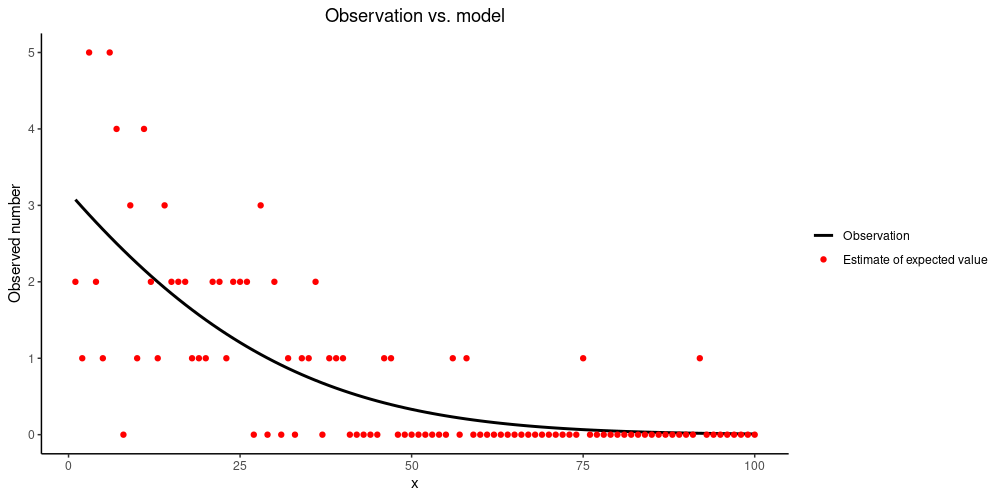

In [46]:
## 結果のプロット
data_plot <- rbind(data.frame(x = x,
                              y = lny,
                              label = "obs"),
                   data.frame(x = x,
                              y = exp(estpars[2]*x + estpars[3]*x**2 + estpars[1]),
                              label = "fit"))

data_plot$label <- factor(data_plot$label, levels = c("fit", "obs"))

ggplot(data = data_plot, aes(x = x, y = y)) +
    geom_line(aes(linewidth = label), color = "black") +
    geom_point(aes(color = label)) +
    scale_color_manual(values = c(obs = "red", fit = "#ffffff00"),
                       label = c("Observation", "Estimate of expected value")) +
    scale_linewidth_manual(values = c(obs = 0, fit = 1),
                           label = c("Observation", "Estimate of expected value")) +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation vs. model") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())

# 正規分布に基づく回帰

データ$y_i$、説明変数$x_i={0, 1,..., 99, 100}$で、誤差構造を

$$
P(y_i | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left( - \frac{(y_i - \mu)^2}{2\sigma^2} \right)
$$

と考える。正規分布の平均$\mu$について線形予測子を用いて

$$
\psi \left( \mu \right) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

と表し、リンク関数$\psi$を対数関数とすることで、回帰を行う。

In [50]:
nobs2 <- 100 ## データの数
x <- 1:nobs2 ## 説明変数
set.seed(5432) ## 乱数のシード値
lny <- rnorm(n = nobs1, mean = exp(-(.03*x + .0001*x**2 - 1.0)), sd = 0.15) ## 正規分布からランダムサンプリング

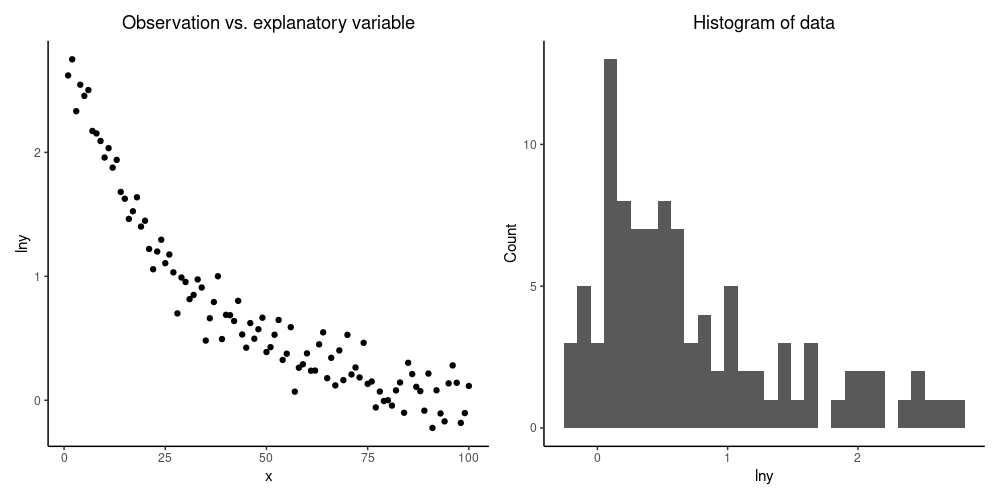

In [51]:
## データのプロット

p1 <- ggplot(data = data.frame(x = x, y = lny), aes(x = x, y = y)) +
    geom_point() +
    xlab("x") +
    ylab("lny") +
    labs(title = "Observation vs. explanatory variable") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(data = data.frame(x = lny), aes(x = x)) +
    geom_histogram(bins = 30) +
    xlab("lny") +
    ylab("Count") +
    labs(title = "Histogram of data") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

In [58]:
## 誤差構造：ガウス分布（正規分布） / リンク関数：対数 / 線形予測子：beta_0 + beta_1*x^2 + beta_2*x^2
data_gauss <- data.frame(x1 = x, x2 = x^2, y = lny)
gauss_log <- glm(y ~ x1 + x2, data = data_gauss, family = gaussian(link = "log"),
                 start = c(1, 0.01, 0.001))
summary(gauss_log)


Call:
glm(formula = y ~ x1 + x2, family = gaussian(link = "log"), data = data_gauss, 
    start = c(1, 0.01, 0.001))

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.044e+00  2.614e-02  39.961   <2e-16 ***
x1          -3.529e-02  2.629e-03 -13.420   <2e-16 ***
x2          -3.052e-05  4.684e-05  -0.652    0.516    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.02073641)

    Null deviance: 55.2535  on 99  degrees of freedom
Residual deviance:  2.0113  on 97  degrees of freedom
AIC: -98.849

Number of Fisher Scoring iterations: 19


In [59]:
estpars <- gauss_log[["coefficients"]]

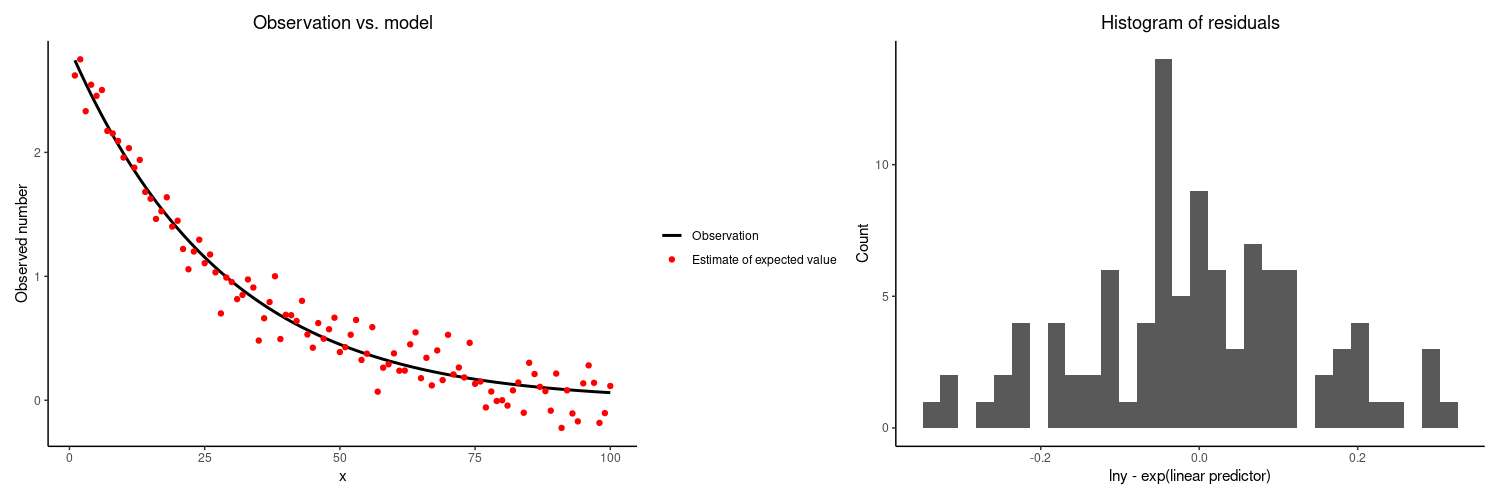

In [66]:
## 結果のプロット
data_plot <- rbind(data.frame(x = x,
                              y = lny,
                              label = "obs"),
                   data.frame(x = x,
                              y = exp(estpars[2]*x + estpars[3]*x**2 + estpars[1]),
                              label = "fit"))

data_plot$label <- factor(data_plot$label, levels = c("fit", "obs"))

p1 <- ggplot(data = data_plot, aes(x = x, y = y)) +
    geom_line(aes(linewidth = label), color = "black") +
    geom_point(aes(color = label)) +
    scale_color_manual(values = c(obs = "red", fit = "#ffffff00"),
                       label = c("Observation", "Estimate of expected value")) +
    scale_linewidth_manual(values = c(obs = 0, fit = 1),
                           label = c("Observation", "Estimate of expected value")) +
    xlab("x") +
    ylab("Observed number") +
    labs(title = "Observation vs. model") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())

p2 <- ggplot(data = data.frame(x = lny - exp(estpars[2]*x + estpars[3]*x**2 + estpars[1])),
             aes(x = x)) +
    geom_histogram(bins = 30) +
    xlab("lny - exp(linear predictor)") +
    ylab("Count") +
    labs(title = "Histogram of residuals") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
          legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 100) ## プロットの描画サイズの設定
p1 + p2

## 負の二項分布に基づく回帰（追記予定）

データ$y_i$、説明変数$x_i={0, 1,..., 99, 100}$で、誤差構造を

$$
P(y_i = k | r, p) = \begin{pmatrix} k + r - 1 \\ r - 1 \end{pmatrix} (1-p)^r p^k 
$$

と考える。ここで期待値は

$$
E[y_i]=\frac{rp}{1-p}
$$

分散は

$$
Var[y_i] = \frac{rp}{(1-p)^2}
$$

と表され、新規のパラメータ$\alpha$を用いて

$$
Var[y_i] = (1 + \alpha)E[y_i]
$$

と表すこととする。

正規分布の母数$\lambda$について線形予測子を用いて

$$
\psi \left( \lambda \right) = \beta_0 + \beta_1 x_i + \beta_2 x_i^2
$$

と表し、リンク関数$\psi$を対数関数とすることで、回帰を行う。